In [ ]:
!unzip "/content/drive/MyDrive/train.zip" -d "/content"
!unzip "/content/drive/MyDrive/test.zip" -d "/content"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tqdm import tqdm

%matplotlib inline

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.io import read_image

from torch.utils.data import Dataset, DataLoader

In [ ]:
TRAIN_DATA_PATH = "/content/train"
TEST_DATA_PATH = "/content/test"

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, csv, train, test, img_dir):
        self.csv = csv
        self.train = train
        self.test = test
        self.img_dir = img_dir
        self.all_image_names = self.csv[:]['img']
        self.all_labels = np.array(self.csv.drop(['img', "id"], axis=1))
        self.train_ratio = int(0.85 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio
        self.id = self.csv["id"]

        if self.train == True:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])
            self.labels = list(self.all_labels[:self.train_ratio])
            self.id = list(self.id[:self.train_ratio])
            
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45),
                transforms.ToTensor(),
            ])
            
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[-self.valid_ratio:-10])
            self.labels = list(self.all_labels[-self.valid_ratio:])
            self.id = list(self.id[-self.valid_ratio:-10])
            
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                transforms.ToTensor(),
            ])
            
        elif self.test == True and self.train == False:
            self.image_names = list(self.all_image_names)
            self.labels = list(self.all_labels)
            self.id = self.csv["id"]
            
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
            ])

    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image = cv2.imread(f"{self.img_dir}/{self.image_names[index]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image = self.transform(image)
        targets = self.labels[index]
        id = self.id[index]
        
        return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32),
            "id": id
        }

In [ ]:
def choose_model(pretrained, requires_grad):
    model = models.resnet50(progress=True, pretrained=pretrained)

    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False

    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True

    model.fc = nn.Linear(2048, 67)
    return model

In [ ]:
def train(model, dataloader, optimizer, criterion, train_data, device):
    print('Training')
    model.train()
    counter = 0
    train_running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        counter += 1
        data, target = data['image'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(data)

        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()

        loss.backward()

        optimizer.step()
        
    train_loss = train_running_loss / counter
    return train_loss

In [ ]:
def validate(model, dataloader, criterion, val_data, device):
    print('Validating')
    model.eval()
    counter = 0
    val_running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            counter += 1
            data, target = data['image'].to(device), data['label'].to(device)
            outputs = model(data)

            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, target)
            val_running_loss += loss.item()
        
        val_loss = val_running_loss / counter
        return val_loss

In [ ]:
model = choose_model(pretrained=True, requires_grad=False).to(device)

lr = 0.0001
epochs = 800
batch_size = 20
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

In [ ]:
train_csv = pd.read_csv('train.csv')

In [ ]:
d = {}
d["id"] = []
d["img"] = []
for i in range(1, 71):
  if i not in d: 
    d[i] = []

In [ ]:
for row in train_csv.iterrows():
  id = row[1][0]
  name = row[1][1]
  s1 = row[1][2]
  s2 = row[1][3]
  s3 = row[1][4]
  s4 = row[1][5]
  s5 = row[1][6]
  s6 = row[1][7]
  s7 = row[1][8]
  s8 = row[1][9]
  for i in d:
    if i == "img":
      d[i].append(name)
    elif i == "id":
      d[i].append(id)
    elif i in [s1, s2, s3, s4, s5, s6, s7, s8]:
      d[i].append(1)
    else:
      d[i].append(0)
      
train_df = pd.DataFrame(d)
train_df.head(1)

,id,img,1,2,3,4,5,6,7,8,...,61,62,63,64,65,66,67,68,69,70
0,807,5-avi-frame24_jpg.rf.5dec372f9195e9a88ff7dd3bd...,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
odd_cols = []
for col in train_df:
  if train_df[col].max() == 0:
    odd_cols.append(col)

In [ ]:
train_df = train_df.drop(odd_cols, axis=1)

In [ ]:
train_df.shape

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f49c25b2ed0>]],
      dtype=object)

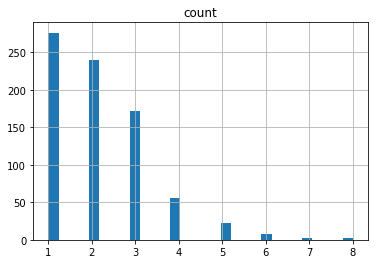

In [ ]:
count_signs = []
for row in train_df.iterrows():
  count_signs.append(sum(row[1][i] for i in range(1, 68) if i not in odd_cols))

df = pd.DataFrame({
    "count": count_signs
})
df.hist(bins=30)

In [ ]:
train_df.head()

In [ ]:
train_df[1]

In [ ]:
train_data = ImageDataset(
    train_df, train=True, test=False, img_dir=TRAIN_DATA_PATH
)

valid_data = ImageDataset(
    train_df, train=False, test=False, img_dir=TRAIN_DATA_PATH
)

train_loader = DataLoader(
    train_data, 
    batch_size=batch_size,
    shuffle=True
)

valid_loader = DataLoader(
    valid_data, 
    batch_size=batch_size,
    shuffle=False
)

Number of training images: 661
Number of validation images: 117


In [ ]:
ckpt = torch.load('/content/drive/MyDrive/outputs/model_epoch_200_12_10_2022.pth')
model.load_state_dict(ckpt["model_state_dict"])

In [ ]:
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss = validate(
        model, valid_loader, criterion, valid_data, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

    if (epoch + 1) % 100 == 0:
      torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, f'/content/drive/MyDrive/outputs/model_epoch_{epoch + 1}_12_10_2022.pth')

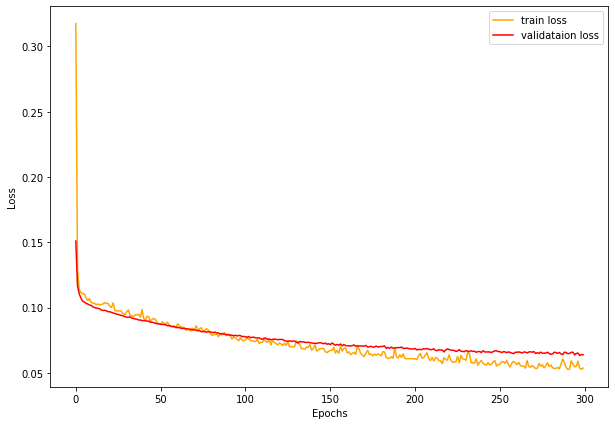

In [ ]:
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, '/content/drive/MyDrive/outputs/model_12_10.pth')

plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(valid_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model = choose_model(pretrained=False, requires_grad=False).to(device)

checkpoint = torch.load('/content/drive/MyDrive/outputs/model_12_10.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

In [ ]:
test_csv = pd.read_csv('test.csv')

test_data = ImageDataset(
    test_csv, train=False, test=True, img_dir=TEST_DATA_PATH
)
test_loader = DataLoader(
    test_data, 
    batch_size=1,
    shuffle=False
)

In [ ]:
def give_sings(number):
  sings = ['3.24', '1.16', '5.15.5', '5.19.1', '5.19.2', '1.20.1', '8.23',
  '2.1', '4.2.1', '8.22.1', '6.16', '1.22', '1.2', '5.16', '3.27',
  '6.10.1', '8.2.4', '6.12', '5.15.2', '3.13', '3.1', '3.20', '3.12',
  '7.14.2', '5.23.1', '2.4', '5.6', '4.2.3', '8.22.3', '5.15.1',  
  '7.3', '3', '2.3.1', '3.11', '6.13', '5.15.4', '8.2.1', '1.34.3',
  '8.2.2', '5.15.3', '1.17', '4.1.1', '4.1.4', '3.25', '1.20.2',
  '8.22.2', '6.9.2', '3.2', '5.5', '5.15.7', '7.12', '8.2.3',
  '5.24.1', '1.25', '3.28', '5.9.1', '5.15.6', '8.1.1', '1.10',
  '6.11', '3.4', '6.10', '6.9.1', '8.2.5', '5.15', '4.8.2', '8.22',
  '5.21', '5.18']
  return sings[number-1]

In [ ]:
d = {}
d["id"] = []
for i in range(1, 9):
  if i not in d: 
    d[f"sing{i}"] = []

In [ ]:
for counter, data in enumerate(test_loader):
    image = data['image'].to(device)

    outputs = model(image)
    outputs = torch.sigmoid(outputs)
    outputs = outputs.detach().cpu()
    sorted_indices = np.argsort(outputs[0])
    best = sorted_indices[-8:]

    d["id"].append(data["id"].cpu().numpy()[0])
    for i in range(len(best)):
      if i < 1:
        d[f"sing{i + 1}"].append(best[i].cpu().numpy())
      else:
        d[f"sing{i + 1}"].append(0)

In [ ]:
sub = pd.DataFrame(d)

In [ ]:
sub.head()

,id,sing1,sing2,sing3,sing4,sing5,sing6,sing7,sing8
0,754,9,28,27,0,0,0,0,0
1,29,1,7,9,0,0,0,0,0
2,1157,28,1,14,0,0,0,0,0
3,1049,27,28,15,0,0,0,0,0
4,715,27,28,0,0,0,0,0,0


In [ ]:
sub.to_csv("sub1.csv", index=None)